In [1]:
import json
import pandas as pd
from collections import defaultdict
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
import networkx as nx
import nltk
# from numpy.random import rand, RandomState
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import string
# from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.basemap import Basemap
# import matplotlib
# import geopy
from sklearn.metrics.pairwise import linear_kernel
from geopy.geocoders import Nominatim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import itertools
import numpy.linalg as LA
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
def json_to_dict(filename):
    '''
    INPUT: name of json file
    OUTPUT: dictionary with city keys and description values
    take json file and return dictionary
    '''
    di = {}
    english = []
    with open('wordlist.txt') as f:
        for line in f:
            english.append(line.strip('\r\n'))
            english.append(' ')
    english = set(english)

    with open(filename) as data_file:
        data = json.load(data_file)
        for item in data:
            for key in item.keys():
                unique_text = set(item[key])
                # remove punctuation, make everything lower case
                txt = ''.join(ch.lower() for ch in unique_text if ch not in set(string.punctuation))
                # remove numbers
                txt = ''.join(c for c in txt if c.isdigit() is False)
                # remove the city and country name from its own description
                keyparts = key.split(',')
                txt = ' '.join(c for c in txt.split() if c.lower() != keyparts[0].lower() and c.lower() != keyparts[-1].lower())
                # remove non-english words
                txt = ' '.join(c for c in txt.split() if c in english)
                # populate dictionary
                di[key.strip().strip('\n').encode('ascii', 'ignore')] = txt
    return di

In [3]:
# def build_synonym_list(word_list):
#     '''
#     INPUT: list of words
#     OUTPUT: list containing words and all of their synonyms
#     take a list of words and return a list containin all synonyms of those words
#     '''
#     all_synonyms = []
#     for word in word_list:
#         synonyms = wn.synsets(word.lower())
#         for s in synonyms:
#             synlist = [l.name() for l in s.lemmas()]
#         synlist.append(word.lower())
#         all_synonyms.extend([wn.lemmatize(w) for w in synlist])
#     return all_synonyms

### Import the data and prepare for tfidf

In [189]:
# rs_dict = json_to_dict('../../data/ricksteves_articles_blogs_R01.json')
# ta_dict = json_to_dict('../../data/europe_city_reviews2.json')
rs_dict = json_to_dict('../../data/ricksteves_articles_blogs_R02.json')
ta_dict = json_to_dict('../../data/ta_combined4.json')

empty_count = 0
for k in ta_dict:
    if len(ta_dict[k]) < 100:
        empty_count += 1
# print empty_count

key_list = set(rs_dict.keys() + ta_dict.keys())
europe_dict = dict()
for key in key_list:
    europe_dict[key] = str(rs_dict.get(key)) + str(ta_dict.get(key))
    
# remove cities which contain little or no text
europe_dict = {key: value for key, value in europe_dict.items() if len(value) > 200}
for k in europe_dict:
    if len(europe_dict[k]) < 100:
        print '\n', k
        print europe_dict[k]

# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(europe_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
# doc_bodies = cities_df['description']
doc_bodies = cities_df['description'].values
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
cities = cities_df.index.values

### Total count and document frequency for nouns, verbs, adverbs, and adjectives

In [5]:
# read each word, assign pos_tag. If pos tag is noun, append dictionary
noun_dict = defaultdict(list)
verb_dict = defaultdict(list)
adj_dict = defaultdict(list)
adv_dict = defaultdict(list)
other_dict = defaultdict(list)

for i, doc in enumerate(tokenized_corpus):
    for word in doc:
        tag = pos_tag([word])[0][1]
        if 'NN' in tag:
            noun_dict[word].append(i)
        if 'JJ' in tag:
            adj_dict[word].append(i)
        if 'VB' in tag:
            verb_dict[word].append(i)
        if 'RB' in tag:
            adv_dict[word].append(i)
        if tag == 'EX' or tag == 'IN' or tag == 'FW' or tag == 'PDT' or tag == 'CD' or tag == 'MD':
            other_dict[word].append(i)
            

### Kmeans Clustering

In [6]:
def kmeans_clustering(doc_bodies, n=12, stpwords=[]):
    '''
    INPUT: corpus, number of clusters, custom stopwords
    OUTPUT: kmeans model and features
    take a document corpus, number of cluster, and custom stopwords and kmeans model to tfidf matrix
    '''
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + stpwords)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)

    top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
    print "top features for each cluster:"
    for num, centroid in enumerate(top_centroids):
        print "%d: %s" % (num, ", ".join(features[i] for i in centroid))
    return kmeans, features

In [7]:
def get_cluster_center(word_list):
    wordnet = WordNetLemmatizer()
    word_dict = dict()  # record synonyms and lemmas for each word in a dictionary
    for word in word_list:
        subset = [word]
        for s in wn.synsets(word.lower()):
            synlist = [l.name() for l in s.lemmas()]
            subset.extend([wordnet.lemmatize(w) for w in synlist])
        word_dict[word] = set(subset)
    syns = set([item for sublist in word_dict.values() for item in sublist])

    edge_list = []
    for syn in syns: 
        keys_lst = [key for key, value in word_dict.items() if syn in value]
        if len(keys_lst) > 1:
            edge_list.extend(list(itertools.combinations(keys_lst, 2)))
    G=nx.Graph()
    G.add_edges_from(edge_list)

    max_deg = Counter(nx.degree_centrality(G)).most_common(1)[0][0]
    nbrs = G.neighbors(max_deg)
    return max_deg

In [8]:
def get_word_stats(noun_dict, verb_dict, adj_dict, adv_dict, other_dict, word):
    parts_of_speech = ['noun', 'verb', 'adjective', 'adverb', 'other']
    
    noun_stats = noun_dict.get(word)
    verb_stats = verb_dict.get(word)
    adj_stats = adj_dict.get(word)
    adv_stats = adv_dict.get(word)
    other_stats = other_dict.get(word)
    
    speech_parts = np.array([noun_stats, verb_stats, adj_stats, adv_stats, other_stats])
    
    word_pos = np.argmax(speech_parts)
    
    return parts_of_speech[word_pos], word_pos, len(speech_parts[word_pos]), len(set(speech_parts[word_pos]))

In [9]:
def get_stopwords_count(speech_dicts, word_count, word_pos, greater_than=True):
    vals = speech_dicts[word_pos].values()
    wds = np.array(speech_dicts[word_pos].keys())
    word_counts = np.array([len(val) for val in vals])
    if greater_than:
        return wds[word_counts >= word_count]
    else:
        return wds[word_counts <= word_count]

In [10]:
def get_stopwords(speech_dicts, doc_frequency, word_pos, greater_than=True):
    vals = speech_dicts[word_pos].values()
    wds = np.array(speech_dicts[word_pos].keys())
    doc_freqs = np.array([len(set(val)) for val in vals])
    if greater_than:
        return wds[doc_freqs >= doc_frequency]
    else:
        return wds[doc_freqs <= doc_frequency]

In [11]:
def calculate_cosine_sim(doc_bodies, check_words, stops):
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + stops)
    
    X = vectorizer.fit_transform(np.append(doc_bodies, check_words))
    cosine_similarities = linear_kernel(X, X)

    return cosine_similarities[-1, :-1]

In [12]:
def plot_personality_map(m, cosine_similarities, xpts, ypts, citylist):
    fig = plt.figure(figsize=(19, 9))
    cosine_similarities = np.array(cosine_similarities)
    sz = 20. * cosine_similarities / max(cosine_similarities) + 6
    alp = (cosine_similarities / max(cosine_similarities))/1.5 + 0.3
    fs = 15 * cosine_similarities / max(cosine_similarities)

    for i in xrange(len(xpts)):
        plt.plot(xpts[i], ypts[i], '.', markersize=sz[i], color='#81D8D0', alpha=alp[i])
        plt.text(xpts[i], ypts[i], citylist[i], fontsize=int(fs[i]), alpha=alp[i], color=[1,1,1])
    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    m.drawmapboundary(fill_color='#2B3856')
    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='#786D5F',lake_color='#2B3856')

    plt.savefig('city_sample.jpg', bbox_inches='tight')
    plt.show()

In [197]:
def plot_word_frequencies(tokenized_corpus, title):
    '''
    INPUT: tokenized corpus, plot title
    OUTPUT: vocabulary list, word ids, word counts
    take a tokenized corpus, calculate the frequency of each word, and plot
    '''
    '''Build a vocabulary of every unique word in the corpus'''
    vocab_set = set()
    [[vocab_set.add(token) for token in tokens] for tokens in tokenized_corpus]
    vocab = list(vocab_set)
    
    '''Make a dictionary relating word to id number'''
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    '''Build word count matrix'''
    word_ids = np.zeros(len(vocab))
    word_counts = np.zeros((len(tokenized_corpus), len(vocab)))
    for doc_id, words in enumerate(tokenized_corpus):
        for word in words:
            word_id = vocab_dict[word]
            word_ids[word_id] = word_id
            word_counts[doc_id][word_id] += 1
    
    '''Count the total number of times each word occurs'''
    values = np.sum(word_counts, axis=0)
    
    '''Plot the results'''
    plt.bar(range(0,len(values)), sorted(values)[::-1], color='green', alpha=0.4)

    plt.xlabel('Word Index')
    plt.ylabel('Frequency')
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])
    plt.title('Word Frequency Chart - {}'.format(title))
#     return np.array(values), vocab, word_ids

In [14]:
def remove_stopwords(corpus, words_to_add=[]):
    '''
    INPUT: tokenized document corpus, list of words to remove
    OUTPUT: document corpus with stop words removed
    take a list of words to add to stoplist and remove from corpus
    '''
    '''Use the English language stopwords provided by nltk'''
    stops = stopwords.words('english')
    
    '''Add user-requested stopwords'''
    stops.extend(words_to_add)
    
    '''Remove stop words from corpus and return'''
    #tokenized = [word_tokenize(content.lower()) for content in corpus]
    stops = set(stops)
    docs = [[word for word in words if word not in stops]
        for words in corpus]
    
    return docs

In [15]:
def limit_speech_part(corpus, pts_of_speech = ['ADJ', 'NOUN', 'ADV', 'VERB']):
    '''
    INPUT: tokenized corpus, list of parts of speech to keep
    OUTPUT: list of words to remove
    take a tokenized corpus and return a list of words to remove from that are not in the part of speech list
    '''
    remove_words = []
    for words in corpus:
        for word in words:
            check = 0
            for ps in pts_of_speech:
                check += len(wn.synsets(word, pos=getattr(wn, ps)))
            if check == 0:
                remove_words.append(word)
    return remove_words

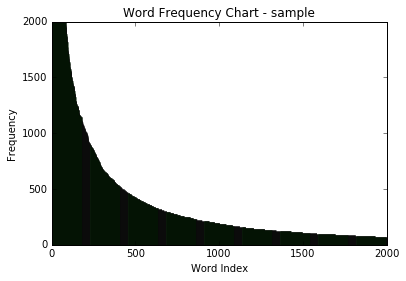

In [198]:
tokenized_corpus_0 = remove_stopwords(tokenized_corpus)
plot_word_frequencies(tokenized_corpus_0,'sample')

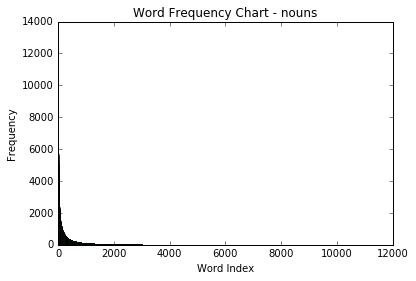

In [17]:
non_nouns = limit_speech_part(tokenized_corpus_0, pts_of_speech = ['NOUN'])
tokenized_corpus_nouns = remove_stopwords(tokenized_corpus_0, non_nouns)
plot_word_frequencies(tokenized_corpus_nouns, 'nouns')

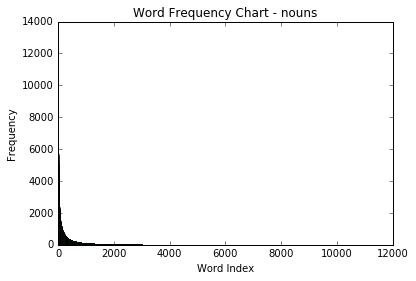

In [18]:
non_nouns = limit_speech_part(tokenized_corpus_0, pts_of_speech = ['NOUN'])
tokenized_corpus_nouns = remove_stopwords(tokenized_corpus_0, non_nouns)
plot_word_frequencies(tokenized_corpus_nouns, 'nouns')

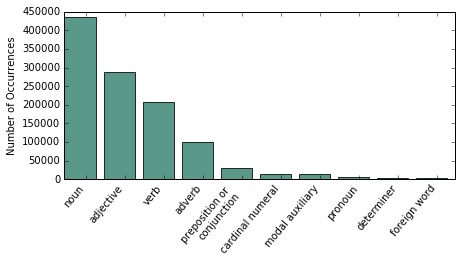

In [196]:
tagged = []
for doc in tokenized_corpus_0:
    tagged.extend(pos_tag(doc))
counts = Counter(tag for word,tag in tagged)

pos_keys = counts.keys()

general_dict = defaultdict(int)
for k in pos_keys:    
    general_dict[k[0:2]] += counts[k]
    
vals = np.array(general_dict.values())
sort_inds = np.array(np.argsort(vals)[::-1])
ks = np.array(general_dict.keys())

ind = np.arange(10)  # the x locations for the groups
width = 0.55       # the width of the bars

pos_dict = {'CC': 'conjunction', 'CD': 'cardinal numeral', 'DT': 'determiner', 'EX': 'existential there', 'FW': 'foreign word',
'IN': 'preposition or \nconjunction', 'JJ': 'adjective', 'LS': 'list item marker', 'MD': 'modal auxiliary', 'NN': 'noun',
'PD': 'pre-determiner', 'PO': 'genitive marker', 'PR': 'pronoun', 'RB': 'adverb', 'RP': 'particle', 'SY': 'symbol',
'TO': '"to" as preposition or infinitive marker', 'UH': 'interjection', 'VB': 'verb',  'WD': 'WH-determiner',
'WP': 'WH-pronoun', 'WR': 'Wh-adverb'}

label = [pos_dict[p] for p in ks[sort_inds][:10]]

fig, ax = plt.subplots(figsize=(7,3))
top_indices = np.array(np.argsort(vals)[::-1][:8])
plt.bar(range(0,10), vals[sort_inds][:10], color='#317f6c', alpha=0.8)
ax.set_xticks(ind + width)
ax.set_xticklabels(label, rotation=50, ha='right')
plt.ylabel('Number of Occurrences')
plt.savefig('part_of_speech_frequency.png', bbox_inches='tight')
plt.show()

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195]
<type 'numpy.ndarray'>


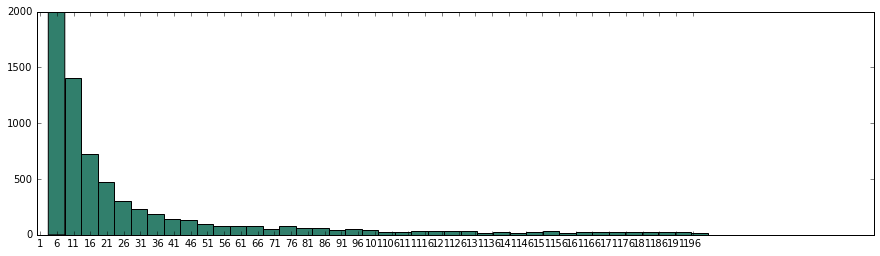

In [247]:
doc_freq = np.array([len(set(n)) for n in noun_dict.values()])
noun_dict.keys()

fig, ax = plt.subplots(figsize=(15,4))
ind = np.arange(40)
print ind*5
width = 1
print type(doc_freq)
plt.hist(doc_freq, bins=40, align='right', color='#317f6c', rwidth=1)
ax.set_xticks(ind*5+width)
plt.ylim([0, 2000])
plt.show()

In [239]:
print noun_dict.keys()[0:10]

['writings', 'nunnery', 'yellow', 'revelers', 'billing', 'woods', 'aegis', 'ornate', 'woody', 'cyprus']


In [173]:
df_g = sorted(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 192, 3, greater_than=True))
c_g = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 2258, 3, greater_than=True))

df_l = sorted(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 3, greater_than=False))
c_l = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 3, greater_than=False))

print 'comfortingly' in c_l
print c_l

True
['absurdly', 'abundantly', 'agapanthus', 'aloft', 'alternately', 'amusingly', 'andunfortunately', 'andwhere', 'animatedly', 'annoyingly', 'appealingly', 'appreciatively', 'attentively', 'bayadere', 'bewilderingly', 'biologically', 'blatantly', 'callously', 'carelessly', 'cashmere', 'ceremonially', 'ceremoniously', 'cheekily', 'cheerfully', 'chemically', 'cleanly', 'coherently', 'comfortingly', 'competently', 'constructively', 'contrastingly', 'cozily', 'criminally', 'daringly', 'dazzlingly', 'demurely', 'devotedly', 'diametrically', 'diplomatically', 'discouragingly', 'disgustingly', 'distinctively', 'divinely', 'drily', 'educationally', 'eminently', 'emphatically', 'energetically', 'entertainingly', 'ethnically', 'excitingly', 'exorbitantly', 'expensively', 'explicitly', 'exponentially', 'faintly', 'fastidiously', 'financially', 'forcefully', 'frighteningly', 'fundamentally', 'furiously', 'furst', 'geometrically', 'ghastly', 'glacially', 'goodly', 'graphically', 'grisly', 'grossl

In [175]:
stp_wds = []
# nouns
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 181, 0, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 4485, 0, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1, 0, greater_than=False))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 0, greater_than=False))

# verbs
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 194, 1, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 4968, 1, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 1, greater_than=False))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 1, greater_than=False))

# adjectives
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 155, 2, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 929, 2, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 2, greater_than=False))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 2, greater_than=False))

# adverbs
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 192, 3, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 2258, 3, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 3, greater_than=False))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 3, greater_than=False))

# Two letter words
for lst in tokenized_corpus:
    stp_wds.extend([word for word in lst if len(word) < 3])

print len(stp_wds)
print len(set(stp_wds))

623082
4278


### Try snowball and porter stemmers prior to tfidf

In [ ]:
snowball = SnowballStemmer('english')
docs_snowball = [' '.join([snowball.stem(word) for word in words.split()]) for words in doc_bodies]

In [ ]:
dict_snowball = defaultdict(list)
stem_stops = []
# for each word, check if adjective. if adjective, add original word to dictionary list
for words in doc_bodies:
    for word in words.split():
        if 'JJ' in pos_tag([word])[0][1]:
            dict_snowball[snowball.stem(word)].append(word)
        else:
            stem_stops.append(snowball.stem(word))

In [ ]:
print len(dict_snowball.keys())

In [ ]:
# adj_dict = defaultdict(list)
# adj_stem_dict = defaultdict(list)
# for i, doc in enumerate(tokenized_corpus):
#     for word in doc:
#         tag = pos_tag([word])[0][1]
#         if 'JJ' in tag:
#             adj_dict[word].append(i)
#             adj_stem_dict[snowball.stem(word)].append(i)

In [ ]:
s1 = sorted(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 78, 2, greater_than=True))
s2 = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 377, 2, greater_than=True))

s3 = sorted(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 2, greater_than=False))
s4 = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1, 2, greater_than=False))

# print 'comfortable' in s1
# print 'cultural' in s1
# print 'informative' in s1

# print 'informative' in s2
# print 'quiet' in s2
# print 'private' in s2

# print 'zealous' in s4

In [ ]:
stpwds = set(s1 + s2 + s3 + s4)
print len(stpwds)
stem_stops_add = [snowball.stem(word) for word in stpwds]

### Generate stop words

In [ ]:
stopwds = []
for words in docs_snowball:
    for word in words.split():
        if len(dict_snowball[word]) < 1:
            stopwds.append(word)

            pos_dicts = np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict])           
stopwds.extend([snowball.stem(word) for word in get_stopwords(pos_dicts, 78, 2, greater_than=True)])
stopwds.extend([snowball.stem(word) for word in get_stopwords_count(pos_dicts, 925, 2, greater_than=True)])
stopwds.extend([snowball.stem(word) for word in get_stopwords_count(pos_dicts, 1, 2, greater_than=False)])

removelist = '''swedish,french,polish,swiss,italian,likely,finnish,german,norwegian,portuguese,american,spanish,\
scottish,russian,belgian,irish,actual,tuscan,arrive,vatican,affected,especial,british,nordic,flemish,venetian,\
soviet,golden,unknown,possible,detailed,useful,vertical,alphabetical,noteworthy,basic,valuable,slovenian,manageable,\
experienced,particular,numbered,essential,final,estuary,weekly,regular,flat,related,continuous,continued,mixed,\
estonian,advisable,characteristic,satisfied,black,vulcan,oldest,biggest,prepared,baltic,similar,georgian,\
portuguese,portugues,japanes,indonesian,numer,averag,facial,easier,older,parisian,andalusian,februari,anatolian,\
larger,northern,true,upper,tini,ethnograph,austrian,daili,bigger,highest,greatest,characteristic,eastern,victorian,\
low,high,pedestrian,heavi,higher,gothic,nuclear,temporari'''.split(',')
stopwds.extend([snowball.stem(word) for word in removelist])
print len(set(stopwds))

In [ ]:
syns = wn.synsets('intelligent')
for s in syns:
    print s.lemmas()

In [ ]:
kmeans, features = kmeans_clustering(docs_snowball, n=8, stpwords=stem_stops + stem_stops_add + removelist)
# kmeans = kmeans_clustering(X,)
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
cluster_cents = []
print '\n'
for i, centroid in enumerate(top_centroids):
    wordlist = []

    for j in centroid:
        wordlist.extend(list(set(dict_snowball[features[j]])))
    print ', '.join(wordlist)

In [ ]:
with open('personalities.txt') as f:
    for line in f:
        personality = line.strip('\n').split(', ') # read words on each line of file
#         personality = ['great', 'awesome']
        top5 = np.argsort(cosine_similarities)[::-1][:5]
   
        # pull from original calculation
        vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
        Xorig = vectorizer.fit_transform(np.append(doc_bodies, ' '.join(personality)))
        cs = linear_kernel(Xorig, Xorig)
        print 'Original cosine similiarty 0:', cs[-1, :-1][0]
        print cosine_similarities[0]
        
        # test a new calculation
        vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
        X = vectorizer.fit_transform(doc_bodies)
        
        c = vectorizer.transform(np.array([' '.join(personality), ]))
        print X.shape
        print c.shape
        
        csnew = X*c.T
        data = cosine_similarity(X, c)

        for num in top5:
            print cities[num]

        print '\n'    
        top5new = np.argsort(data[:,0])[::-1][:5]
        for n in top5new:
            print cities[n]

In [ ]:
m = Basemap(projection='stere', lon_0=5, lat_0=72.0, rsphere=6371200., llcrnrlon=-15.0,
            urcrnrlon=74.0, llcrnrlat=32.0, urcrnrlat=55.0, resolution='l')

geolocator = Nominatim()
xpts = []
ypts = []
for i, city in enumerate(cities):
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        xpts.append(xpt)
        ypts.append(ypt)

In [ ]:
m = Basemap(projection='stere', lon_0=5, lat_0=72.0, rsphere=6371200., llcrnrlon=-15.0,
            urcrnrlon=72.0, llcrnrlat=32.0, urcrnrlat=55.0, resolution='l')

plot_personality_map(m, cosine_similarities, xpts, ypts, cities)